#### Sources :
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

- https://towardsdatascience.com/multilabel-text-classification-done-right-using-scikit-learn-and-stacked-generalization-f5df2defc3b5

#### Imports

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [136]:
df = pd.read_csv('datasets/full_df.csv')

In [137]:
df.labels.unique().tolist()

['football', 'autre']

In [138]:
df['category_id'] = df['labels'].factorize()[0]
df['category_id'] = df['category_id'] + 1


In [139]:
category_id_df = df[['labels', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'labels']].values)

Drop de description car cela ne donne pas réellement d'information supplémentaire sur le contenu :

In [140]:
df = df.drop(columns=['description', 'title'])

In [141]:
df.head()

,article_text,labels,category_id
0,Le président de Flamengo a rejeté les spécula...,football,1
1,Alors qu'il n'a toujours pas retrouvé de banc...,football,1
2,L’équipe nationale algérienne sera de sortie ...,football,1
3,"Un petit point sépare Troyes, douzième, d'Aux...",football,1
4,"Le défenseur central du FC Barcelone, Gerard ...",football,1


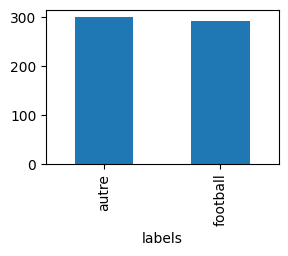

In [142]:
fig = plt.figure(figsize=(3,2))
df.groupby('labels').article_text.count().plot.bar(ylim=0)
plt.show()

Le dataset est bien équilibré

Text Processing :

Ici, l'objectif est de transformer les morceaux de texte afin de pouvoir les utiliser dans le model 

Creation d'une liste de stopwords fr :

(source : https://github.com/stopwords-iso/stopwords-fr/blob/master/stopwords-fr.txt )

In [143]:
stopwords_fr = open('stopwords_fr.txt').read().splitlines()

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords_fr)
features = tfidf.fit_transform(df.article_text).toarray()
labels = df.category_id
features.shape

/Users/robinfournier/Desktop/YNOV/NLP/NLP_articles_p1/nlp1venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


(593, 3227)

1er fit & predict

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['article_text'], df['labels'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [181]:
print(clf.predict(count_vect.transform(["Defense droit"])))

['football']


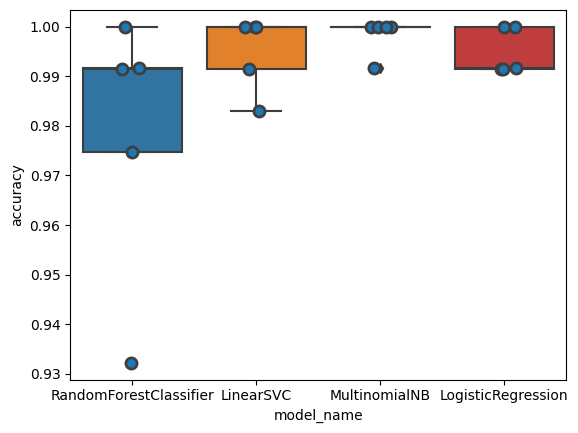

In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [184]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.994915
LogisticRegression        0.994929
MultinomialNB             0.998319
RandomForestClassifier    0.978023
Name: accuracy, dtype: float64

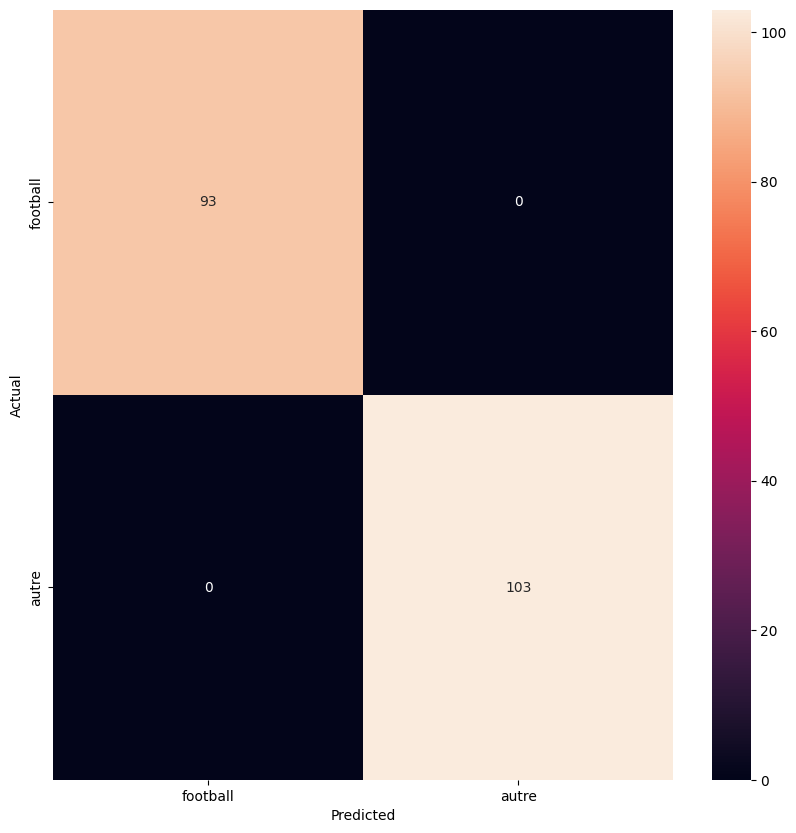

In [192]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.labels.values, yticklabels=category_id_df.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [194]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['labels'].unique()))

              precision    recall  f1-score   support

    football       1.00      1.00      1.00        93
       autre       1.00      1.00      1.00       103

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196

